# Colab Notebook for SAM2 segmentation

written by Dr.Yusuke Kimata (Ueda G)<br>
ref: Notebook in GitHub (https://github.com/facebookresearch/segment-anything-2/tree/main/notebooks)

SAM2による動画セグメンテーション

”/content/drive/MyDrive/Colab Notebooks/SAM2/”を作業元ディレクトリとする<br>
inputはファイル名が数字の羅列になったjpegしか処理できない (ex. 000.jpg, 001.jpg, ...)<br>
ランタイムのタイプを"GPU"に変更しておく

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/

import os
HOME = os.getcwd()
print("HOME:", HOME)

#!git clone https://github.com/facebookresearch/segment-anything-2.git #二度目以降はこの行をコメントアウト

%cd {HOME}/segment-anything-2

Mounted at /content/drive
/content/drive/MyDrive
HOME: /content/drive/MyDrive
fatal: destination path 'segment-anything-2' already exists and is not an empty directory.
/content/drive/MyDrive/segment-anything-2


In [ ]:
!pip install -e . -q
!python setup.py build_ext --inplace

  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.6 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done
running build_ext
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:497: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
/usr/local/lib/python3.10/dist-packages

In [ ]:
!pip install -q supervision[assets] jupyter_bbox_widget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.7 MB/s eta 0:00:00


### Download SAM2 checkpoints

**NOTE:** SAM2 is available in 4 different model sizes ranging from the lightweight "sam2_hiera_tiny" (38.9M parameters) to the more powerful "sam2_hiera_large" (224.4M parameters).

In [ ]:
# 二度目以降は不要
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

### Imports

In [ ]:
import cv2
import torch
import base64

import json

import numpy as np
import supervision as sv

import matplotlib.pyplot as plt
from glob import glob
from natsort import natsorted
from google.colab.patches import cv2_imshow

from pathlib import Path
from supervision.assets import download_assets, VideoAssets
from sam2.build_sam import build_sam2_video_predictor

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

**NOTE:** This code enables mixed-precision computing for faster deep learning. It uses bfloat16 for most calculations and, on newer NVIDIA GPUs, leverages TensorFloat-32 (TF32) for certain operations to further boost performance.

In [ ]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [ ]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

# マスク描画用関数
def show_mask(mask, ax, obj_id=None):
    cmap = plt.get_cmap("tab10")
    cmap_idx = 0 if obj_id is None else obj_id
    color = np.array([*cmap(cmap_idx)[:3], 0.3])

    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

# プロンプト描画用関数（point）
def show_points(coords, labels, ax, marker_size=30):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='o', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='x', s=marker_size, linewidth=1.25)

# プロンプト描画用関数（box）
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

# マスク描画用関数（cv2）
def show_mask_cv2(image, mask, obj_id=None):
    cmap = plt.get_cmap("tab10")
    cmap_idx = 0 if obj_id is None else obj_id
    color = np.array([*cmap(cmap_idx)[:3], 0.3]) * 255
    h, w = mask.shape[-2:]

    mask_image = (mask.reshape(h, w, 1) * color[:3]).astype(np.uint8)

    overlay = cv2.addWeighted(image, 1, mask_image, 0.2, 0)
    return overlay

# マスク保存用関数（8bitグレースケール）
def save_mask_grayscale(mask, output_path):
    h, w = mask.shape[-2:]

    mask_image = (mask.reshape(h, w) * 255).astype(np.uint8)

    cv2.imwrite(output_path, mask_image)

## Load model

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

## Segmentation

In [ ]:
# モデル準備
predictor = build_sam2_video_predictor(CONFIG, CHECKPOINT)

In [ ]:
# 入力・出力ディレクトリ名
input_name = "input_img_MT"
output_name = "output_img_MT"

input_img_dir = "/content/drive/MyDrive/Colab Notebooks/SAM2/" + input_name + "/"
output_img_dir = "/content/drive/MyDrive/Colab Notebooks/SAM2/" + output_name + "/"

# ディレクトリが存在しない場合に作成
os.makedirs(input_img_dir, exist_ok=True)
os.makedirs(output_img_dir, exist_ok=True)

# 確認
print(f"Input directory: {os.path.exists(input_img_dir)}")
print(f"Output directory: {os.path.exists(output_img_dir)}")

Input directory: True
Output directory: True


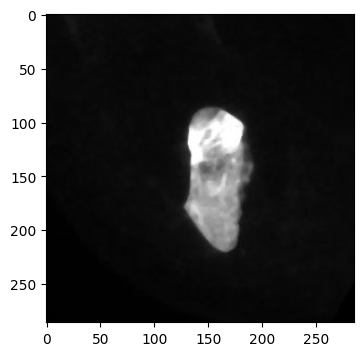

In [ ]:
# 動画の最初のフレームを取得
frame_names = natsorted(glob(f"{input_img_dir}*.jpg"))
img = cv2.imread(frame_names[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 描画
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis('on')
plt.show()

### Initialize the inference state

**NOTE:** SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an inference state on this video. During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [ ]:
# 新しい動画を処理する前には必ず実行
inference_state = predictor.init_state(video_path=input_img_dir)

frame loading (JPEG): 100%|██████████| 49/49 [00:39<00:00,  1.24it/s]


**NOTE:** If you have run any previous tracking using this inference_state, please reset it first via reset_state. (The cell below is just for illustration; it's not needed to call reset_state here as this inference_state is just freshly initialized above.)

In [ ]:
# 新しい動画を処理する前には必ず実行
predictor.reset_state(inference_state)

### Prompting with points

In [ ]:
OBJECTS = ['object', 'bg'] #背景部分をbgとする

**NOTE:** Let's choose the index of the reference frame that we will use to annotate the objects we are looking for.

In [ ]:
FRAME_IDX = 0 #フレーム番号
OBJECT_ID = 1
FRAME_PATH = f"{input_img_dir}{FRAME_IDX:03d}.jpg"

widget = BBoxWidget(classes=OBJECTS)
widget.image = encode_image(FRAME_PATH)
widget #表示されたウィジェット上でセグメンテーションしたい物体と背景にしたい部分を数か所クリック（表示される点の位置がずれるが気にしない）

BBoxWidget(classes=['object', 'bg'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',…

In [ ]:
# widget.bboxesの座標データをcoordinatesとして受け取る
coordinates = widget.bboxes

# ディレクトリ名を使ってファイル名を作成
dir_name = os.path.basename(os.path.normpath(input_img_dir))  # ディレクトリ名のみ抽出
os.makedirs("/content/drive/MyDrive/Colab Notebooks/SAM2/prompts/", exist_ok=True)
output_file = "/content/drive/MyDrive/Colab Notebooks/SAM2/prompts/" + f'coordinates_{dir_name}_frame{FRAME_IDX}.txt'  # ファイル名を生成

# テキストファイルに座標データを保存
with open(output_file, 'w') as file:
    # 一行目にFRAME_PATHを書き込み
    file.write(f'FRAME_PATH = "{FRAME_PATH}"\n')

    # 座標データをJSON形式で保存
    json.dump(coordinates, file, indent=4)


In [ ]:
widget.bboxes #出力を下のセルの'default_boxにコピペ or このセルはスキップ

In [ ]:
default_box = []

boxes = widget.bboxes if widget.bboxes else default_box
input_point = np.array([
    [
        box['x'],
        box['y']
    ] for box in boxes
])
# 'bg' ラベルを 0、それ以外を 1 にする
input_label = np.array([
    0 if box['label'] == 'bg' else 1 for box in boxes
])

In [ ]:
## 指定したフレームに対する入力プロンプトのセグメンテーションを計算
_, out_obj_ids, out_mask_logits = predictor.add_new_points(
    inference_state=inference_state,
    frame_idx=FRAME_IDX,
    obj_id=OBJECT_ID,
    points=input_point,
    labels=input_label,
)

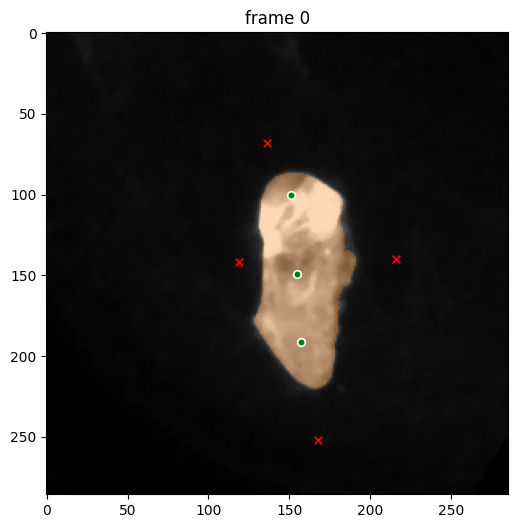

In [ ]:
# 結果の描画
plt.figure(figsize=(6, 6))
plt.title(f"frame {FRAME_IDX}")
image = cv2.imread(frame_names[FRAME_IDX])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [ ]:
# 動画の全フレームに対してセグメンテーションを実行
video_segments = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

In [ ]:
# 数フレームごとに表示して確認
vis_frame_stride = 30

plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    image = cv2.imread(frame_names[out_frame_idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        image = show_mask_cv2(image, out_mask, obj_id=out_obj_id)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        print(f"frame {out_frame_idx}")
        cv2_imshow(image)


## リファレンスフレームの追加（optional）

In [ ]:
# 動画の別のフレームを取得
FRAME_IDX = 20
OBJECT_ID = 1
img2 = cv2.imread(frame_names[FRAME_IDX])
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# 描画
plt.figure(figsize=(4, 4))
plt.imshow(img2)
plt.axis('on')
plt.show()

In [ ]:
FRAME_PATH = f"{input_img_dir}{FRAME_IDX:03d}.jpg"

widget2 = BBoxWidget(classes=OBJECTS)
widget2.image = encode_image(FRAME_PATH)
widget2
#表示された画像上でセグメンテーションしたい物体と背景にしたい部分をクリック

In [ ]:
# widget.bboxesの座標データをcoordinatesとして受け取る
coordinates = widget2.bboxes

# ディレクトリ名を使ってファイル名を作成
dir_name = os.path.basename(os.path.normpath(input_img_dir))  # ディレクトリ名のみ抽出
output_file = "/content/drive/MyDrive/Colab Notebooks/SAM2/prompts/" + f'coordinates_{dir_name}_frame{FRAME_IDX}_.txt'  # ファイル名を生成

# テキストファイルに座標データを保存
with open(output_file, 'w') as file:
    # 一行目にFRAME_PATHを書き込み
    file.write(f'FRAME_PATH = "{FRAME_PATH}"\n')

    # 座標データをJSON形式で保存
    json.dump(coordinates, file, indent=4)

In [ ]:
default_box = []

boxes = widget2.bboxes if widget2.bboxes else default_box
input_point = np.array([
    [
        box['x'],
        box['y']
    ] for box in boxes
])
# 'bg' ラベルを 0、それ以外を 1 にする
input_label = np.array([
    0 if box['label'] == 'bg' else 1 for box in boxes
])

_, out_obj_ids, out_mask_logits = predictor.add_new_points(
    inference_state=inference_state,
    frame_idx=FRAME_IDX,
    obj_id=OBJECT_ID,
    points=input_point,
    labels=input_label,
)

In [ ]:
plt.figure(figsize=(6, 6))
plt.title(f"frame {FRAME_IDX}")
image = cv2.imread(frame_names[FRAME_IDX])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [ ]:
# 動画の全フレームに対してセグメンテーションを実行
video_segments = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

In [ ]:
# 数フレームごとに表示して確認
vis_frame_stride = 30

plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    image = cv2.imread(frame_names[out_frame_idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        image = show_mask_cv2(image, out_mask, obj_id=out_obj_id)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        print(f"frame {out_frame_idx}")
        cv2_imshow(image)

## マスクの保存

以下の2つのいずれかを実行（出力先が同じになっているので後に実行した方に上書きされる）

### マスクをグレースケールで保存する場合

In [ ]:
# フレームごとに保存
for out_frame_idx in range(len(frame_names)):
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        basename = os.path.basename(frame_names[out_frame_idx])
        output_frame = os.path.join(output_img_dir, basename)

        # マスクを8ビットグレースケールで保存
        save_mask_grayscale(out_mask, output_frame)


### 元画像にマスクを重ねて保存の場合

In [ ]:
for out_frame_idx in range(len(frame_names)):
    # 元画像の読み込み
    image = cv2.imread(frame_names[out_frame_idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # マスクを重ね合わせ
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        image = show_mask_cv2(image, out_mask, obj_id=out_obj_id)

    # 結果を保存
    basename = os.path.basename(frame_names[out_frame_idx])
    output_frame = os.path.join(output_img_dir, basename)

    # 画像を保存
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_frame, image)
